In [1]:
%matplotlib inline
import matplotlib


In [36]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle

In [37]:
#load data
print "loading data"
#iterate over directory and get all png images\n
imageset = np.empty((7704,64,64,3), dtype='float32')

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chsarath/kaushal_project/mug/models/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 36:
                cnt = 0
                total_cnt += 1
            cnt += 1
            seq_number = int(filepath.split('-')[-1].split('.')[0])
            
            imageset[total_cnt*36 + seq_number] = misc.imread(filepath).astype(np.float32)
            
print 'loading done'

loading data
loading done


(64, 64, 3)


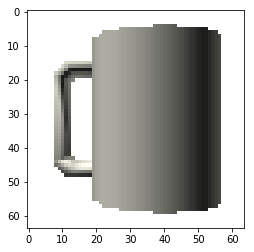

In [38]:
#this part is to visulize image
tmp = imageset[69+65]
print tmp.shape
plt.imshow(tmp/255)
plt.show()


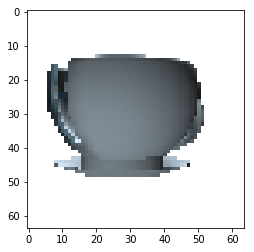

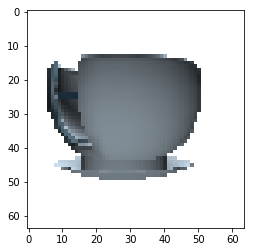

In [39]:
#First 170 folders. 170*36 = 6120 images would be used for training
# rest 46 folders would be used for testing


labels = np.array(imageset)

for cnt in range(216):
    labels[cnt*36:(cnt+1)*36] = np.roll(imageset[cnt*36:(cnt+1)*36], 1, axis=0)

imageset, labels = shuffle(imageset, labels, random_state=0)

data_train = np.array(imageset[:6120])
data_test = np.array(imageset[6120:])


#This code will generate labels for the dataset

# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image

train_labels = np.array(labels[:6120])
test_labels = np.array(labels[6120:])

# #Comment here for autoencoder
# for cnt in range(170):
#     train_labels[cnt*36:(cnt+1)*36] = np.roll(data_train[cnt*36:(cnt+1)*36], 1, axis=0)

# for cnt in range(46):
#     test_labels[cnt*36:(cnt+1)*36] = np.roll(data_test[cnt*36:(cnt+1)*36], 1, axis=0)
# # comment ends for same image autoencoder

#tmp = data_test[600]

#Hidden viewpoint block is generated here.
# For now it is same for all images. 10 degree angle change
# it will change afterwards
'''
view_1d = np.zeros(36)
view_1d[1] = 1
view = np.broadcast_to(view_1d,(7776,8,8,36))
view_train = view[:6120]
view_test = view[6120:]
'''


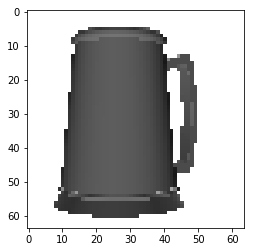

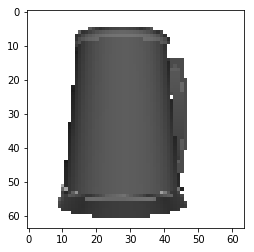

In [47]:

tmp = train_labels[223][...,::-1]
tmp1 = data_train[223][...,::-1]


plt.imshow(tmp/255)
plt.show()
plt.imshow(tmp1/255)
plt.show()

In [48]:
#normalize data


data_train *= 2
data_train /= 255
data_train -= 1

data_test *= 2
data_test /= 255
data_test -= 1


train_labels *= 2
train_labels /= 255
train_labels -= 1

test_labels *= 2
test_labels /= 255
test_labels -= 1



In [49]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [50]:
#defination of my layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    

    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape)

In [51]:

# Network Parameters

#Encoder
# input is 64 * 64 * 3 
# batch_size is 72


# tf Graph input (only pictures)

inputs_ = tf.placeholder(tf.float32, (36, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (36, 64,64,3), name="target")


In [52]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Max pool + Conv + relu  + Max pool + Conv + relu  + Max pool
# After 3 Convolution ,we will have a latent space

with tf.variable_scope('conv1'):
    conv1 = conv2d(inputs_, 3, 2, 16)
    tanh1 = tf.nn.relu(conv1)
    #pool1 = max_pool(tanh1, 3, 2)

# Size of pool1 would be 32*32*32

with tf.variable_scope('conv2'):
    conv2 = conv2d(tanh1, 3, 2, 32)
    tanh2 = tf.nn.relu(conv2)
    #pool2 = max_pool(tanh2, 3, 2)

# # Size of pool2 would be 16*16*16

with tf.variable_scope('conv3'):
    conv3 = conv2d(tanh2, 3, 2, 64)
    tanh3 = tf.nn.relu(conv3)
    #pool3 = max_pool(tanh3, 3, 2)

# # Latent space is 8*8*8
# print pool3.get_shape().as_list()
# #Building the decoder

with tf.variable_scope('deconv1'):
    deconv1 = deconv2d(tanh3, 3, 2, 32)
    tanh4 = tf.nn.relu(deconv1)

print tanh4.get_shape().as_list()
with tf.variable_scope('deconv2'):
    deconv2 = deconv2d(tanh4, 3, 2, 16)
    tanh5 = tf.nn.relu(deconv2)
print tanh5.get_shape().as_list()

with tf.variable_scope('deconv3'):
    deconv3 = deconv2d(tanh5, 3, 2, 3)
    tanh6 = tf.nn.tanh(deconv3)



[36, 16, 16, 32]
[36, 32, 32, 16]


In [53]:

#calculate loss
loss_op = tf.reduce_mean(abs(tanh6 - targets_))

#Optimizer
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)



In [54]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training Parameters

epochs = 50
batch_size = 36
total_images = 6120

display_step = 1000
examples_to_show = 10


for e in range(epochs):
    for ii in range(total_images // batch_size):
        batch = data_train[ii*batch_size : (ii+1)*batch_size]
        batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        feed_dict = {inputs_: batch, targets_: batch_labels}

        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=feed_dict)
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Training loss: {:.4f}".format(loss))


('Epoch: 1/50...', 'Training loss: 0.7747')
('Epoch: 1/50...', 'Training loss: 0.7919')
('Epoch: 1/50...', 'Training loss: 0.7837')
('Epoch: 1/50...', 'Training loss: 0.7711')
('Epoch: 1/50...', 'Training loss: 0.7715')
('Epoch: 1/50...', 'Training loss: 0.7747')
('Epoch: 1/50...', 'Training loss: 0.7781')
('Epoch: 1/50...', 'Training loss: 0.7827')
('Epoch: 1/50...', 'Training loss: 0.7381')
('Epoch: 1/50...', 'Training loss: 0.8031')
('Epoch: 1/50...', 'Training loss: 0.7825')
('Epoch: 1/50...', 'Training loss: 0.7784')
('Epoch: 1/50...', 'Training loss: 0.7690')
('Epoch: 1/50...', 'Training loss: 0.7821')
('Epoch: 1/50...', 'Training loss: 0.8006')
('Epoch: 1/50...', 'Training loss: 0.7748')
('Epoch: 1/50...', 'Training loss: 0.8147')
('Epoch: 1/50...', 'Training loss: 0.7813')
('Epoch: 1/50...', 'Training loss: 0.7913')
('Epoch: 1/50...', 'Training loss: 0.7683')
('Epoch: 1/50...', 'Training loss: 0.7707')
('Epoch: 1/50...', 'Training loss: 0.7906')
('Epoch: 1/50...', 'Training los

(64, 64, 3)


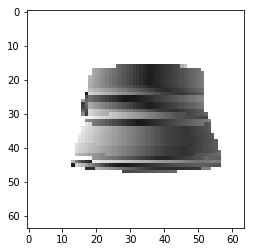

In [56]:

#compare test image 

tmp = imageset[6120+71][...,::-1]
print tmp.shape
plt.imshow(tmp/255)
plt.show()


In [60]:


feed_dict = {inputs_: data_test[:36], targets_: test_labels[:36]}

fetches = [tanh6, loss_op]
out, loss = sess.run(fetches, feed_dict=feed_dict)
print loss

0.0946854


In [61]:
other = np.array(out)

print other.shape

(36, 64, 64, 3)


In [ ]:
# test_labels_copy = test_labels[0:72]

# test_labels_copy *= max_labels
# test_labels_copy += mean_labels

# tmp = test_labels_copy[36]

# tmp = np.where(tmp>255,255,tmp)
# tmp = np.where(tmp<0,0,tmp)
# tmp = tmp
# plt.imshow(tmp)
# plt.show()

In [ ]:
out = other

In [62]:

out += 1
out *=  255
out /= 2

# print np.amax(out)
# print np.amin(out)
# out = np.where(out>255,255,out)
# out = np.where(out<0,0,out)



(64, 64, 3)


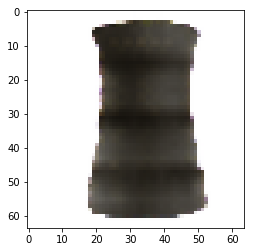

In [74]:

tmp = out[12]
print tmp.shape
plt.imshow(tmp/255)
plt.show()

In [69]:
test_labels += 1
test_labels *=  255
test_labels /= 2

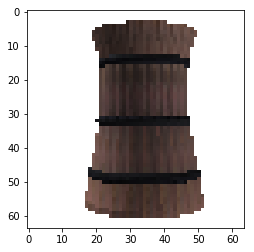

In [73]:
tmp = test_labels[12]
plt.imshow(tmp/255)
plt.show()